## Agent Movie Manager

This notebook demonstrates a simple Retrieval-Augmented Generation (RAG) proof of concept using LangGraph. It showcases how to build an agent that can interact with a movie database, leveraging LLMs and tool integration. The workflow is designed for easy experimentation and visualization in LangGraph Studio, making it ideal for demonstrations and rapid prototyping.

Load environment variables follow use .env.example as reference

In [50]:
import dotenv
dotenv.load_dotenv()

True

### Tool list_movies

The `list_movies` tool retrieves all movies stored in the database. It uses the `MovieRepository` to access and return a list of `Movie` objects, each representing a movie entry with its details (such as name, release year, rating, IMAX availability, and price).

In [51]:
from langchain_openai import ChatOpenAI
from common.models.movie import Movie
from common.repositories.movie_repository import MovieRepository

def list_movies() -> list[Movie]:
    """List all movies in the database."""
    repository = MovieRepository()
    movies = repository.all()
    return movies

tools = [list_movies]


### Initialize LLM and Bind Tools

We initialize the `ChatOpenAI` language model with the desired configuration and bind the available tools (such as `list_movies`) to the model. This enables the LLM to invoke these tools during conversation.

```python
llm = ChatOpenAI(
    model="gpt-4o",
)

llm_with_tools = llm.bind_tools(tools)
```

In [52]:
llm = ChatOpenAI(
    model="gpt-4o",
)

llm_with_tools = llm.bind_tools(tools)

### Assistant Node Implementation

The assistant node is responsible for generating responses using the language model and invoking tools when necessary. It takes the current conversation state, prepends a system message to guide the assistant's behavior, and passes the messages to the language model with tool bindings. The output is a dictionary containing the updated list of messages.

- **Input:** `state` (current conversation state containing messages)
- **Process:** Adds a system prompt, invokes the LLM with tool support
- **Output:** Updated messages, including the assistant's response or tool call

This design enables the assistant to flexibly respond to user queries and utilize available tools as needed.

In [53]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

sys_msg = SystemMessage(
    content="You are a helpful assistant that can list movies from the database."
)

def assistant(state: MessagesState):
    return { "messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}



## Build Graph

This section constructs the conversational workflow using LangGraph's stateful graph API. The graph orchestrates the interaction between the assistant (LLM) and available tools, enabling dynamic tool invocation based on user input.

- **Nodes:**  
    - `assistant`: Handles user queries, generates responses, and determines if a tool should be called.
    - `tools`: Executes tool functions (e.g., `list_movies`) when requested by the assistant.

- **Edges:**  
    - The graph starts at the `assistant` node.
    - If the assistant's response includes a tool call, control flows to the `tools` node; otherwise, the conversation ends.
    - After tool execution, control returns to the `assistant` node for further processing.

- **Visualization:**  
    The graph structure is visualized using Mermaid, providing a clear overview of the workflow.

This modular design allows for easy extension with additional tools or logic, supporting flexible and interactive agent behaviors.

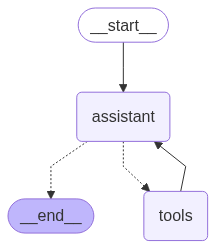

In [54]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [55]:
messages = [HumanMessage(content="List all movies in the database.")]
messages = react_graph.invoke({"messages": messages}) # type: ignore

In [56]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

List all movies in the database.
================================== Ai Message ==================================
Tool Calls:
  list_movies (call_GtLdz0ABoOc0Z6Fiwaw770tz)
 Call ID: call_GtLdz0ABoOc0Z6Fiwaw770tz
  Args:
================================= Tool Message =================================
Name: list_movies

[<Movie(id=1, name=Consumer staff begin, description=Police nation shake market race. Interview natural moment college meet partner.
Sound experience benefit. Real give consider full wall own. Tough central another kitchen., release_year=1996, rating=4.1, is_imax=False, price=15.57, created_at=2025-08-07 13:48:23)>, <Movie(id=2, name=Deal consumer owner, description=Right each pay series position sort newspaper option. Management evening agree member without not.
Arm act fly bring east his woman structure. Budget century skill must lot., release_year=2016, rating=8.4, is_imax=True, price=14.